In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('/content/labeled_twitter_depressive_full_clean_km2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123984 entries, 0 to 123983
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   text            123984 non-null  object 
 1   depression      123984 non-null  float64
 2   not_depression  123984 non-null  float64
 3   cluster         123984 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 3.8+ MB


In [ ]:
df = df.drop(['depression', 'not_depression'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123984 entries, 0 to 123983
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     123984 non-null  object
 1   cluster  123984 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.9+ MB


In [ ]:
df.shape

(123984, 2)

In [ ]:
df.groupby('cluster').count()

,text
cluster,
0,70509
1,53475


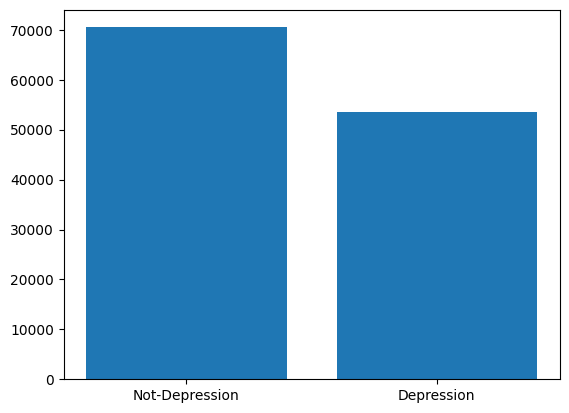

In [ ]:
classes = df.cluster.unique()
counts = []

for i in classes:
  count = len(df[df.cluster==i])
  counts.append(count)

plt.bar(['Not-Depression', 'Depression'], counts)
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

X = df['text']
encoder = LabelEncoder()
y = encoder.fit_transform(df['cluster'])
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

shape of input data:  (123984,)
shape of target variable:  (123984,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 5000
max_len = 200
embedding_dim = 128

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')
vocab_size = len(word_index) + 1

X_train_tweets = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_tweets = pad_sequences(X_test_sequences, maxlen=max_len)

Found 77237 unique tokens.


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

oversample = SMOTE(sampling_strategy=1, random_state=42)
over_X_train, over_y_train = oversample.fit_resample(X_train_tweets, y_train)
#over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.20, random_state=42, stratify=over_y)

In [ ]:
from collections import Counter

print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(over_y_train)))

Original dataset shape Counter({0: 56407, 1: 42780})
Resampled dataset shape Counter({0: 56407, 1: 56407})


In [ ]:
print(np.count_nonzero(over_y_train == 0))
print(np.count_nonzero(over_y_train == 1))

print(np.count_nonzero(y_test == 0))
print(np.count_nonzero(y_test == 1))

56407
56407
14102
10695


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# matthews_correlation_coefficient
def mcc_m(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

def balanced_acc_m(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    sensitivity = tp / (tp + fn)
    specifity = tn / (fp + tn)
    return (sensitivity + specifity) / (2 + K.epsilon())

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, GlobalMaxPooling1D, Dropout
from keras.callbacks import ModelCheckpoint

In [ ]:
import keras
keras.__version__

'2.15.0'

In [ ]:
model = Sequential([
  Embedding(vocab_size, embedding_dim, input_length=max_len),
  Conv1D(64, 5, activation='tanh'),
  GlobalMaxPooling1D(),
  Flatten(),
  Dropout(0.5),
  Dense(32, activation='tanh'),
  Dense(8, activation='tanh'),
  Dense(2, activation='tanh'),
  Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.1))
])

#model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy', metrics=['accuracy', balanced_acc_m, precision_m, recall_m, f1_m, mcc_m, keras.metrics.AUC()])
checkpoint = ModelCheckpoint("best_epoch_cnn_model.h5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model.fit(over_X_train, over_y_train, batch_size=64, epochs=50, validation_data=(X_test_tweets, y_test), callbacks=[checkpoint, stop_early])
#model.save('model_cnn_save.keras')

Epoch 1/50
1763/1763 [==============================] - ETA: 0s - loss: 0.5915 - accuracy: 0.7689 - balanced_acc_m: 0.7684 - precision_m: 0.7825 - recall_m: 0.7468 - f1_m: 0.7600 - mcc_m: 0.5386 - auc: 0.8307
Epoch 1: val_accuracy improved from -inf to 0.80534, saving model to best_epoch_cnn_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1763/1763 [==============================] - 43s 21ms/step - loss: 0.5915 - accuracy: 0.7689 - balanced_acc_m: 0.7684 - precision_m: 0.7825 - recall_m: 0.7468 - f1_m: 0.7600 - mcc_m: 0.5386 - auc: 0.8307 - val_loss: 0.5488 - val_accuracy: 0.8053 - val_balanced_acc_m: 0.8055 - val_precision_m: 0.7580 - val_recall_m: 0.8069 - val_f1_m: 0.7784 - val_mcc_m: 0.6070 - val_auc: 0.8720
Epoch 2/50
1763/1763 [==============================] - ETA: 0s - loss: 0.5528 - accuracy: 0.8010 - balanced_acc_m: 0.8011 - precision_m: 0.8082 - recall_m: 0.7910 - f1_m: 0.7966 - mcc_m: 0.6028 - auc: 0.8558
Epoch 2: val_accuracy did not improve from 0.80534
1763/1763 [==============================] - 19s 11ms/step - loss: 0.5528 - accuracy: 0.8010 - balanced_acc_m: 0.8011 - precision_m: 0.8082 - recall_m: 0.7910 - f1_m: 0.7966 - mcc_m: 0.6028 - auc: 0.8558 - val_loss: 0.5548 - val_accuracy: 0.7988 - val_balanced_acc_m: 0.8035 - val_precision_m: 0.7349 - val_recall_m: 0.8358 - val_f1_m: 0.7788 - val_mcc_m: 0.6

In [ ]:
y_predict_cnn = model.evaluate(X_test_tweets, y_test, verbose=0)
y_predict_cnn

[0.5694849491119385,
 0.7982417345046997,
 0.7987381219863892,
 0.7498919367790222,
 0.8011658787727356,
 0.7684445977210999,
 0.5929214954376221,
 0.8299544453620911]

(0.0, 0.5978001356124878)

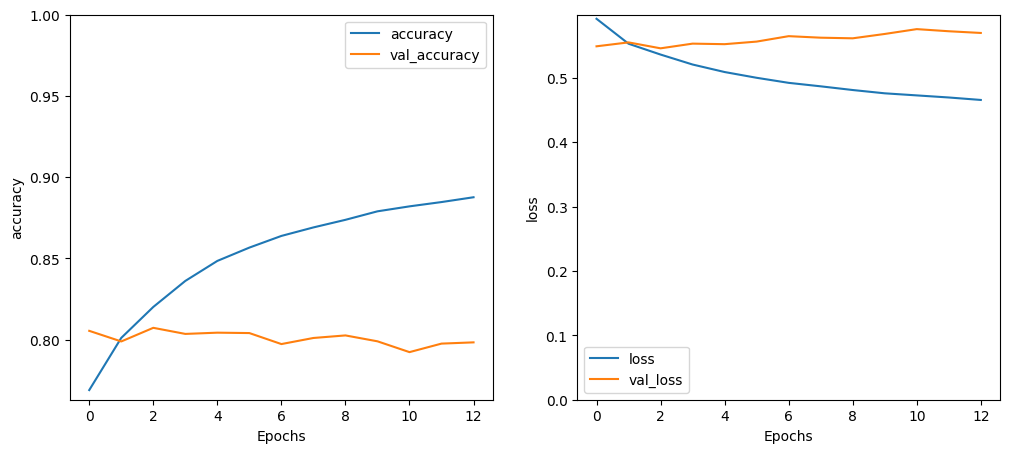

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
history.history

{'loss': [0.5914984345436096,
  0.5527589321136475,
  0.5359479188919067,
  0.5204784870147705,
  0.5088170170783997,
  0.4998719096183777,
  0.4920227527618408,
  0.48662397265434265,
  0.48088109493255615,
  0.4757653474807739,
  0.47253236174583435,
  0.4692951440811157,
  0.46546441316604614],
 'accuracy': [0.7688584923744202,
  0.8009998798370361,
  0.8200489282608032,
  0.8360753059387207,
  0.8483964800834656,
  0.8565958142280579,
  0.8637846112251282,
  0.869023323059082,
  0.8737035989761353,
  0.8789334893226624,
  0.8819916248321533,
  0.8846420049667358,
  0.8876026272773743],
 'balanced_acc_m': [0.7684146761894226,
  0.8011001944541931,
  0.8201211094856262,
  0.8358449339866638,
  0.8483445644378662,
  0.8565031290054321,
  0.8641359210014343,
  0.8688309788703918,
  0.8738953471183777,
  0.8788237571716309,
  0.8817313313484192,
  0.8846542239189148,
  0.8875699043273926],
 'precision_m': [0.782537579536438,
  0.8081563115119934,
  0.8275945782661438,
  0.84290266036987

In [ ]:
import json

results_cnn = json.dumps(history.history)

with open('results_cnn_full_clean_smote-train_depressive.json', 'w') as archivo:
    archivo.write(results_cnn)

# Load the CNN model

In [ ]:
metric_list = {"recall_m": recall_m, "precision_m": precision_m, "f1_m": f1_m,
               "mcc_m": mcc_m, "balanced_acc_m": balanced_acc_m}

load_cnn_model = tf.keras.models.load_model('/content/best_epoch_cnn_model.h5', custom_objects=metric_list)

In [ ]:
y_predict_cnn_load = load_cnn_model.evaluate(X_test_tweets, y_test, verbose=0)
y_predict_cnn_load

[0.5456251502037048,
 0.8071944117546082,
 0.8039252161979675,
 0.7756889462471008,
 0.7791041731834412,
 0.7707911133766174,
 0.6067995429039001,
 0.8631511330604553]